In [1]:
! wget https://github.com/lonperman/dataset-naturaleza/archive/refs/heads/main.zip

--2022-12-21 12:42:25--  https://github.com/lonperman/dataset-naturaleza/archive/refs/heads/main.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/lonperman/dataset-naturaleza/zip/refs/heads/main [following]
--2022-12-21 12:42:25--  https://codeload.github.com/lonperman/dataset-naturaleza/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 192.30.255.121
Connecting to codeload.github.com (codeload.github.com)|192.30.255.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [     <=>            ] 346.93M  26.0MB/s    in 13s     

2022-12-21 12:42:38 (27.2 MB/s) - ‘main.zip’ saved [363787683]



In [2]:
!unzip main.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset-naturaleza-main/seg_train/seg_train/mountain/7539.jpg  
  inflating: dataset-naturaleza-main/seg_train/seg_train/mountain/7551.jpg  
  inflating: dataset-naturaleza-main/seg_train/seg_train/mountain/7560.jpg  
  inflating: dataset-naturaleza-main/seg_train/seg_train/mountain/7565.jpg  
  inflating: dataset-naturaleza-main/seg_train/seg_train/mountain/7578.jpg  
  inflating: dataset-naturaleza-main/seg_train/seg_train/mountain/7581.jpg  
  inflating: dataset-naturaleza-main/seg_train/seg_train/mountain/7586.jpg  
  inflating: dataset-naturaleza-main/seg_train/seg_train/mountain/7647.jpg  
  inflating: dataset-naturaleza-main/seg_train/seg_train/mountain/7652.jpg  
  inflating: dataset-naturaleza-main/seg_train/seg_train/mountain/7654.jpg  
  inflating: dataset-naturaleza-main/seg_train/seg_train/mountain/7662.jpg  
  inflating: dataset-naturaleza-main/seg_train/seg_train/mountain/767.jpg  
  inflating: dataset-natur

In [3]:
import numpy as np 
import pandas as pd 
import random
import tensorflow as tf
import os,cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Input, Dropout

In [4]:
paths=['dataset-naturaleza-main/seg_train/seg_train','dataset-naturaleza-main/seg_test/seg_test']
labels = []
for folder in os.listdir(paths[0]):
    labels.append(folder)

print(labels)

['mountain', 'buildings', 'street', 'forest', 'sea', 'glacier']


In [5]:
dicc_labels={i:labels[i] for i in range(0,len(labels))}
dicc_labels

{0: 'mountain',
 1: 'buildings',
 2: 'street',
 3: 'forest',
 4: 'sea',
 5: 'glacier'}

In [6]:
n=[]
s=80
_images=[]
_labels=[]
for j in range(0,2):
  for i,folder in enumerate(labels):
      try:
          for image in os.listdir(paths[j] +'/'+folder):
              img = os.path.join(paths[j]+'/'+folder+'/'+image)
              img = cv2.imread(img)
              img = cv2.resize(img,(s,s))
              #img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #if you want to use scale gray
              _images.append(img)
              _labels.append(i)
      except:
          print("siuu")
  n.append(len(_images))

_images = np.asarray(_images)
_labels = np.asarray(_labels).astype('int64')
print("images-> ",_images.shape)
print("Amount of data per label-> ",np.bincount(_labels))

images->  (17034, 80, 80, 3)
Amount of data per label->  [3037 2628 2883 2745 2784 2957]


In [7]:
from sklearn.preprocessing import StandardScaler
scal = StandardScaler() 
_images =_images.reshape((len(_images),-1))
scal.fit(_images) 
_images_scal = scal.transform(_images) 

In [21]:
from keras.utils import to_categorical

X_train=_images_scal[0:n[0]]
X_test=_images_scal[n[0]:n[1]]

y_train=_labels[0:n[0]]
y_test=_labels[n[0]:n[1]]


X_train =X_train.reshape(len(X_train),s,s,3)
X_test = X_test.reshape(len(X_test),s,s,3)

print("images trained-> ",X_train.shape,"labels train-> ",y_train.shape)
print("labels train by category-> ",np.bincount(y_train))
print("images tested-> ",X_test.shape,"labels train-> ",y_test.shape)
print("label test by category-> ",np.bincount(y_test))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


images trained->  (14034, 80, 80, 3) labels train->  (14034,)
labels train by category->  [2512 2191 2382 2271 2274 2404]
images tested->  (3000, 80, 80, 3) labels train->  (3000,)
label test by category->  [525 437 501 474 510 553]


In [9]:
model = Sequential()
model.add(Input(shape=(s,s,3)))
model.add(Convolution2D(s, kernel_size=3, activation="relu", padding="valid"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(s*2, kernel_size=3, activation="relu", padding="valid"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(s/2, kernel_size=3, activation="relu", padding="valid"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(6, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy",
               metrics=["accuracy","Precision"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 80)        2240      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 80)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 160)       115360    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 160)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 40)        57640     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 40)         0

Epoch 1/10
14/14 [==============================] - 417s 30s/step - loss: 0.7365 - accuracy: 0.7282 - precision: 0.7961
Epoch 2/10
14/14 [==============================] - 421s 30s/step - loss: 0.6905 - accuracy: 0.7488 - precision: 0.8051
Epoch 3/10
14/14 [==============================] - 414s 29s/step - loss: 0.6617 - accuracy: 0.7607 - precision: 0.8149
Epoch 4/10
14/14 [==============================] - 428s 30s/step - loss: 0.6376 - accuracy: 0.7728 - precision: 0.8181
Epoch 5/10
14/14 [==============================] - 430s 31s/step - loss: 0.6064 - accuracy: 0.7815 - precision: 0.8255
Epoch 6/10
14/14 [==============================] - 423s 30s/step - loss: 0.5690 - accuracy: 0.7976 - precision: 0.8361
Epoch 7/10
14/14 [==============================] - 418s 30s/step - loss: 0.5557 - accuracy: 0.8018 - precision: 0.8412
Epoch 8/10
14/14 [==============================] - 423s 30s/step - loss: 0.5552 - accuracy: 0.7993 - precision: 0.8377
Epoch 9/10
14/14 [======================

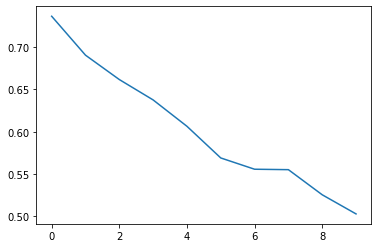

In [15]:
historial=model.fit(X_train, y_train, validation_batch_size=(X_test,y_test),epochs=10,batch_size=1024)
plt.plot(historial.history["loss"])

In [16]:
print(dicc_labels)
pred = model.predict(X_test)
print(classification_report(
    np.argmax(y_test,axis=1),
    np.argmax(pred, axis=1)
))

94/94 [==============================] - 22s 229ms/step
              precision    recall  f1-score   support

           0       0.75      0.83      0.78       525
           1       0.81      0.82      0.81       437
           2       0.86      0.85      0.86       501
           3       0.94      0.94      0.94       474
           4       0.87      0.71      0.78       510
           5       0.76      0.80      0.78       553

    accuracy                           0.82      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.82      0.82      3000

{0: 'mountain', 1: 'buildings', 2: 'street', 3: 'forest', 4: 'sea', 5: 'glacier'}


In [18]:
for i in range(0,15):
  pos= random.randint(0, 2999)
  #print(np.argmax(pred[pos]))
  print("y_pred-> %s vs real-> %s"%(dicc_labels[ np.argmax(pred[pos])] ,dicc_labels[np.argmax(y_test[pos])] ))

y_pred-> forest vs real-> forest
y_pred-> glacier vs real-> glacier
y_pred-> buildings vs real-> street
y_pred-> buildings vs real-> buildings
y_pred-> street vs real-> street
y_pred-> street vs real-> street
y_pred-> glacier vs real-> glacier
y_pred-> street vs real-> street
y_pred-> buildings vs real-> buildings
y_pred-> glacier vs real-> glacier
y_pred-> glacier vs real-> glacier
y_pred-> sea vs real-> sea
y_pred-> street vs real-> street
y_pred-> forest vs real-> forest
y_pred-> buildings vs real-> buildings


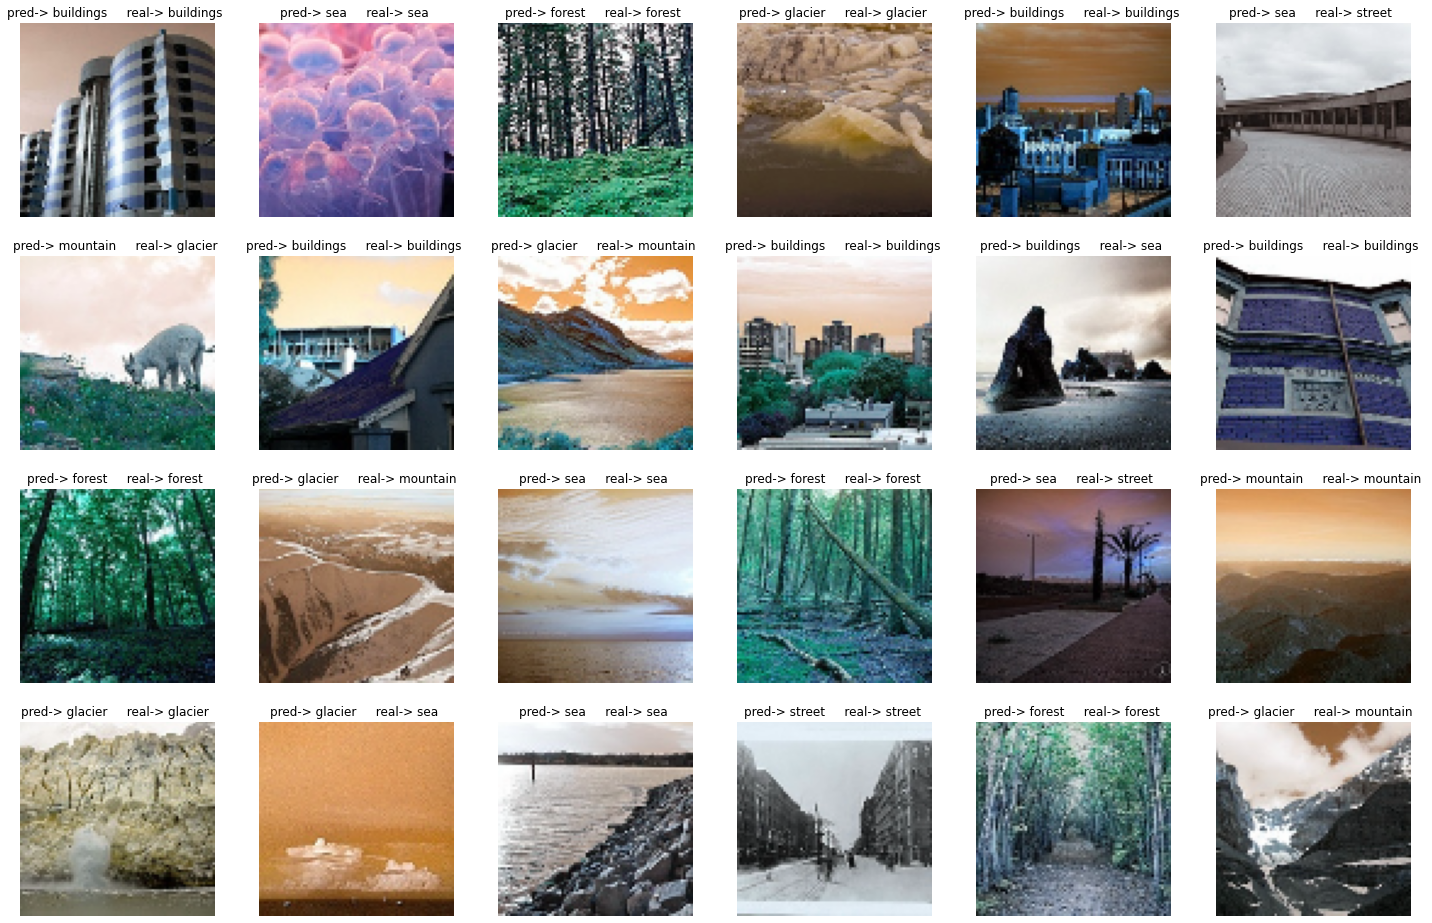

In [19]:
_images =_images.reshape(len(_images),s,s,3)
plt.figure(figsize=(25,25))
for i in range(0,24):
    pos= random.randint(0, 2999)
    plt.subplot(6,6,i+1)
    plt.imshow(_images[n[0]+pos])    
    plt.axis('off')
    plt.title("pred-> %s     real-> %s "%(dicc_labels[np.argmax(pred[pos])],dicc_labels[np.argmax(y_test[pos])]))

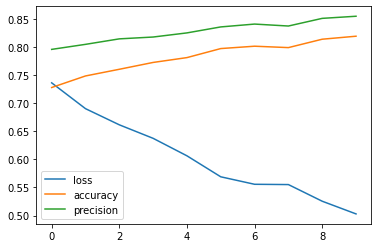

In [20]:
if model:
    for key in historial.history.keys():
        plt.plot(historial.history[key],label=key)
    plt.legend()
    # plt.ylim([0,1])